https://youtu.be/nCMDZEScF-4

**Nuclei segmentation in whole slide H&E images**

using pre-trained StarDist model.

This is pretty much all taken from Dr. Sreenivas Bhattiprolu's github:
https://github.com/bnsreenu/python_for_microscopists/blob/master/281_Segmenting_WSI_using_StarDist.ipynb

In [1]:
!pip install stardist

^C


In [2]:
# To read Tiff files on Colab we need to install imagecodecs library
!pip install imagecodecs  

     ---------------------------------------- 0.0/24.7 MB ? eta -:--:--
     ---------------------------------------- 0.1/24.7 MB 2.8 MB/s eta 0:00:09
     - -------------------------------------- 0.7/24.7 MB 7.1 MB/s eta 0:00:04
     -- ------------------------------------- 1.6/24.7 MB 11.0 MB/s eta 0:00:03
     ---- ----------------------------------- 2.5/24.7 MB 13.5 MB/s eta 0:00:02
     ----- ---------------------------------- 3.5/24.7 MB 14.9 MB/s eta 0:00:02
     ------- -------------------------------- 4.6/24.7 MB 16.2 MB/s eta 0:00:02
     --------- ------------------------------ 5.6/24.7 MB 17.0 MB/s eta 0:00:02
     ---------- ----------------------------- 6.4/24.7 MB 17.1 MB/s eta 0:00:02
     ----------- ---------------------------- 7.2/24.7 MB 17.1 MB/s eta 0:00:02
     ------------ --------------------------- 8.0/24.7 MB 17.1 MB/s eta 0:00:01
     -------------- ------------------------- 8.8/24.7 MB 17.5 MB/s eta 0:00:01
     --------------- ------------------------ 9.6/

In [54]:
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imsave
from csbdeep.utils import Path, normalize
from csbdeep.utils.tf import keras_import
keras = keras_import()

from stardist import export_imagej_rois, random_label_cmap
from stardist.models import StarDist2D

np.random.seed(0)
cmap = random_label_cmap()

In [52]:
def show_image(img, crop_x, crop_y, tile_size, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    ax[0].imshow(img, **kwargs)

    # Crop the image
    cropped_img = img[crop_y:crop_y+tile_size, crop_x:crop_x+tile_size]

    # Plot the cropped image on the right
    ax[1].imshow(cropped_img, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [27]:
import os

pth = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles'  # path of ndpi files
WSIs = [_ for _ in os.listdir(pth) if _.endswith('ndpi')]

pth_mat = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\10x\matfiles'
crop_mats = [_ for _ in os.listdir(pth_mat) if _.endswith('mat')]

In [11]:
imgs = []

for file in WSIs:
    im = imread(os.path.join(pth,file))
    imgs.append(im)

In [12]:
for img in imgs:
    print(img.shape)

(29568, 32640, 3)
(30976, 36480, 3)
(29568, 36480, 3)
(30976, 36480, 3)
(28160, 34560, 3)
(28160, 36480, 3)
(25344, 36480, 3)


In [38]:
from scipy.io import loadmat

def get_crop_info(crop_mat_file_path, ratio) -> tuple:
    data = loadmat(crop_mat_file_path)
    crop_width = int(data['crop_width']*ratio)
    crop_x = int(data['crop_x']*ratio)
    crop_y = int(data['crop_y']*ratio)
    return (crop_x, crop_y, crop_width)


In [41]:
ind=6

mat_file_path = os.path.join(pth_mat, crop_mats[ind])
res20x=0.4416
res10x=1
ratio = res10x/res20x

crop_x, crop_y, tile_size = crop_info = get_crop_info(mat_file_path, ratio)

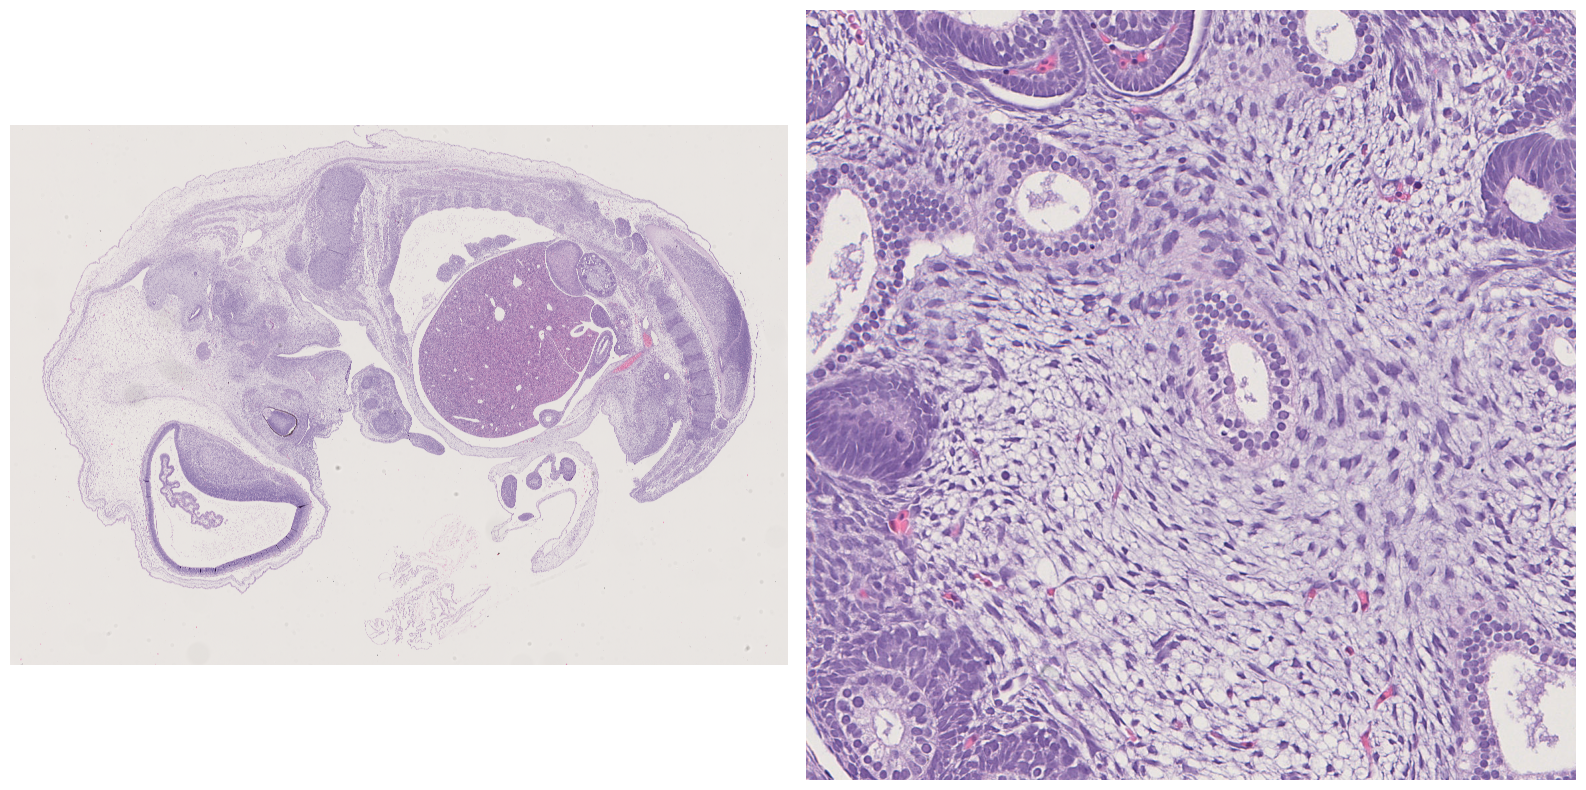

In [53]:
show_image(imgs[6], crop_x, crop_y, tile_size)

In [48]:
model = StarDist2D.from_pretrained('2D_versatile_he')


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [ ]:
# img = normalize(img, 1, 99.8)
# normalizer = None

In [49]:
from csbdeep.data import Normalizer, normalize_mi_ma

class MyNormalizer(Normalizer):
    def __init__(self, mi, ma):
            self.mi, self.ma = mi, ma
    def before(self, x, axes):
        return normalize_mi_ma(x, self.mi, self.ma, dtype=np.float32)
    def after(*args, **kwargs):
        assert False
    @property
    def do_after(self):
        return False

# mi, ma = np.percentile(img[::8], [1,99.8])                      # compute percentiles from low-resolution image
# mi, ma = np.percentile(img[13000:16000,13000:16000], [1,99.8])  # compute percentiles from smaller crop
mi, ma = 0, 255                                                   # use min and max dtype values (suitable here)
normalizer = MyNormalizer(mi, ma)

In [16]:
help(model.predict_instances_big)

Help on method predict_instances_big in module stardist.models.base:

predict_instances_big(img, axes, block_size, min_overlap, context=None, labels_out=None, labels_out_dtype=<class 'numpy.int32'>, show_progress=True, **kwargs) method of stardist.models.model2d.StarDist2D instance
    Predict instance segmentation from very large input images.
    
    Intended to be used when `predict_instances` cannot be used due to memory limitations.
    This function will break the input image into blocks and process them individually
    via `predict_instances` and assemble all the partial results. If used as intended, the result
    should be the same as if `predict_instances` was used directly on the whole image.
    
    **Important**: The crucial assumption is that all predicted object instances are smaller than
                   the provided `min_overlap`. Also, it must hold that: min_overlap + 2*context < block_size.
    
    Example
    -------
    >>> img.shape
    (20000, 20000)
    >>

In [219]:
#Slow - takes time to segment the large image

img = imgs[6]

labels, polys = model.predict_instances_big(img, axes='YXC', block_size=4096, min_overlap=128, context=128,
                                            normalizer=normalizer2, n_tiles=(4,4,1))

effective: block_size=(4096, 4096, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 70/70 [10:17<00:00,  8.82s/it]


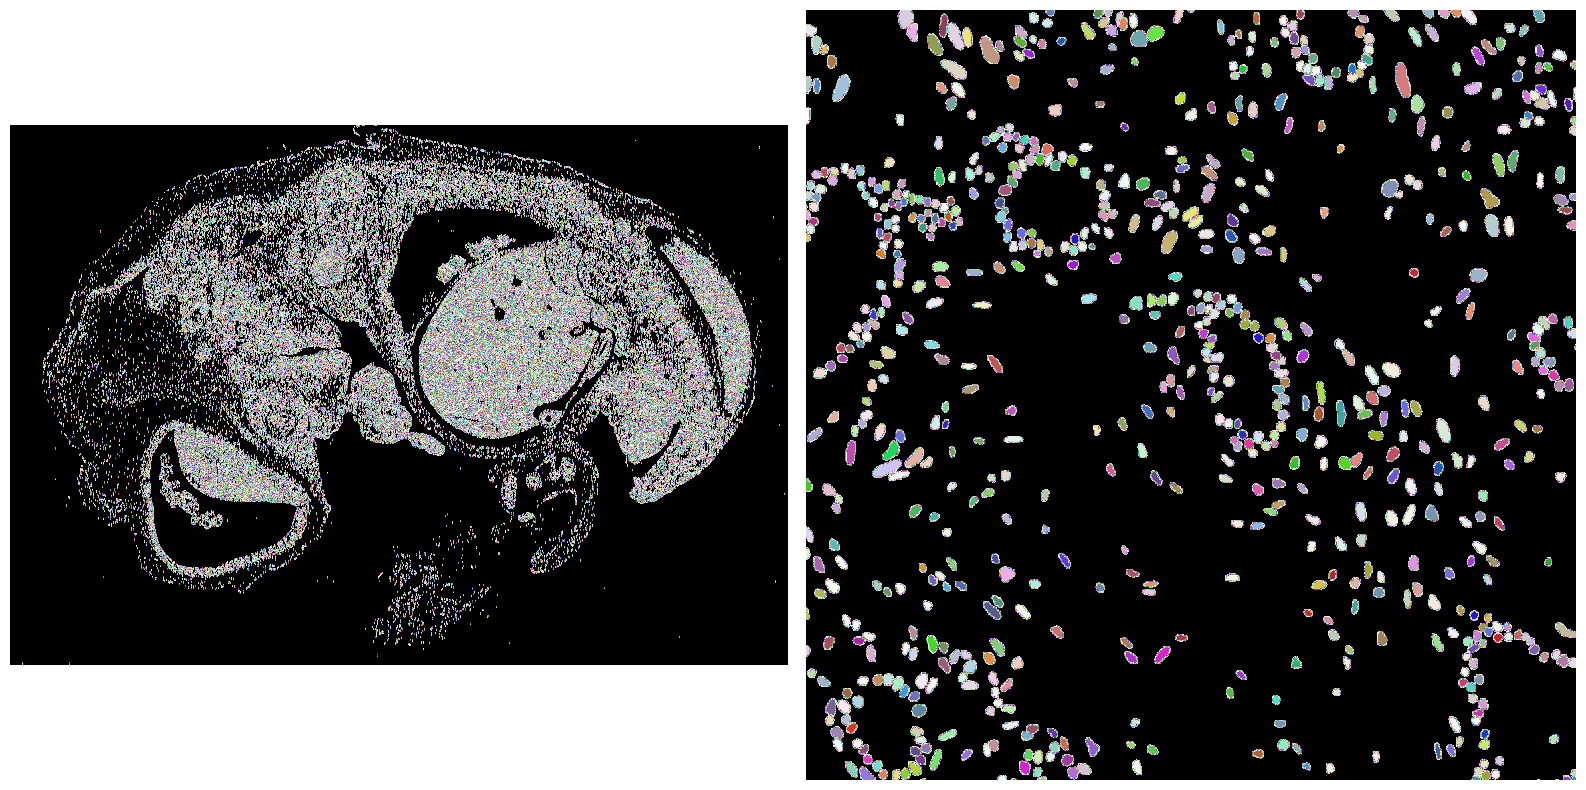

In [220]:
show_image(labels, crop_x, crop_y, tile_size, cmap=cmap)

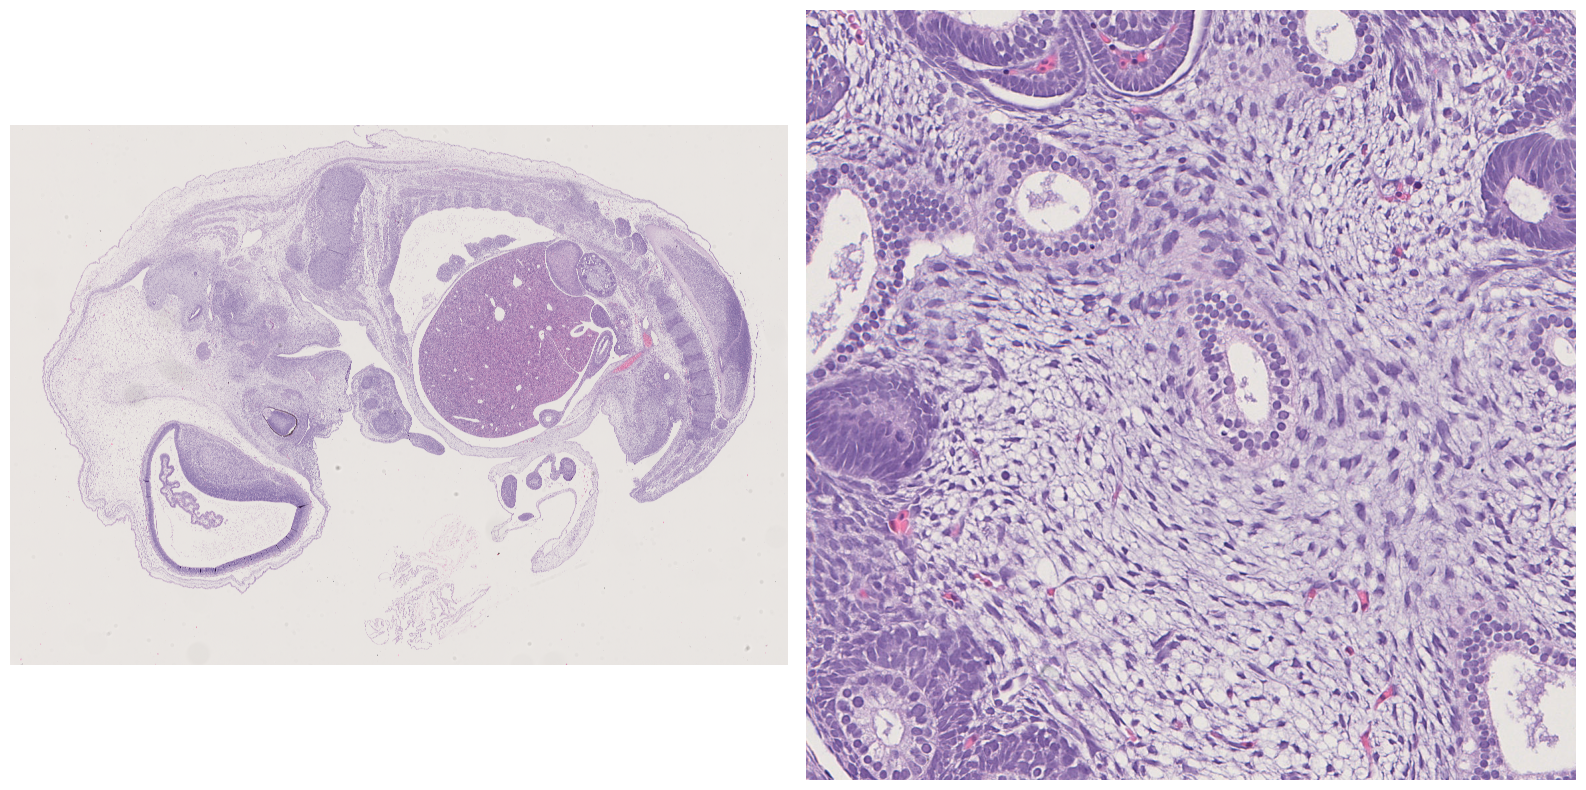

In [57]:
show_image(imgs[6], crop_x, crop_y, tile_size)

In [71]:
def show_tile(tile, **kwargs):
    """Plot a single image."""
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.imshow(tile, **kwargs)
    plt.tight_layout()
    ax.set_axis_off()
    plt.show()

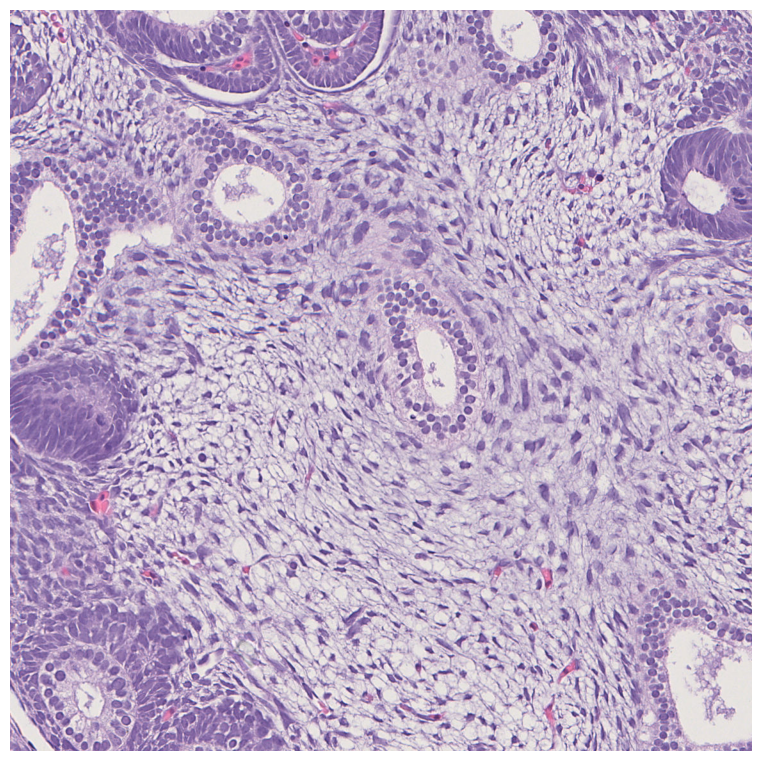

In [72]:
tiles_path = r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\tiles\tiffs'
tiles = [_ for _ in os.listdir(tiles_path) if _.endswith('tiff')]

tile = os.path.join(tiles_path, tiles[6])
tile_im = imread(tile)

show_tile(tile_im)

In [80]:
labels, polys = model.predict_instances(tile_im, normalizer=normalizer)

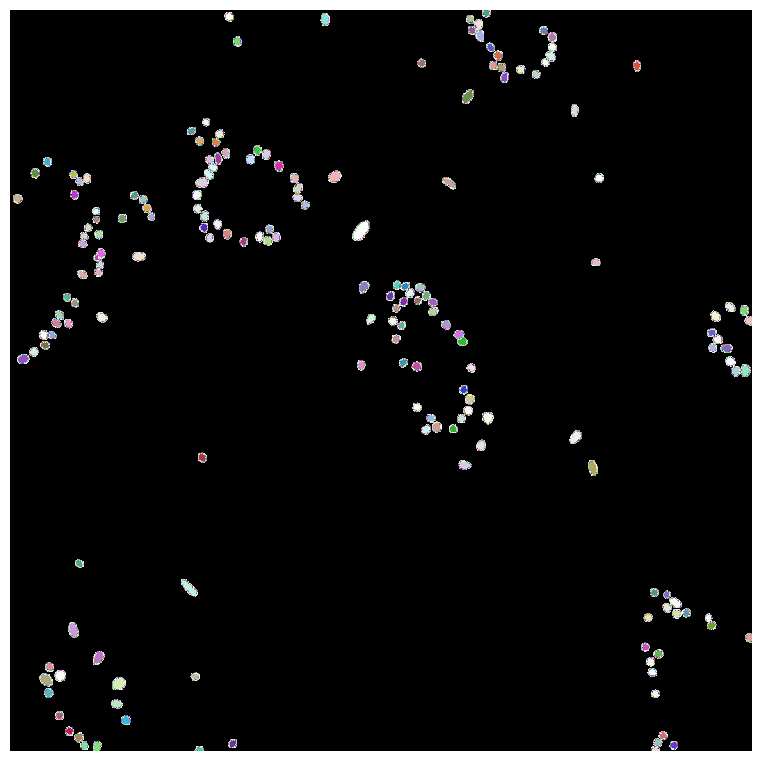

In [81]:
show_tile(labels, cmap = cmap)

In [ ]:
class MyNormalizer(Normalizer):
    def __init__(self, mi, ma):
            self.mi, self.ma = mi, ma
    def before(self, x, axes):
        return normalize_mi_ma(x, self.mi, self.ma, dtype=np.float32)
    def after(*args, **kwargs):
        assert False
    @property
    def do_after(self):
        return False

# mi, ma = np.percentile(img[::8], [1,99.8])                      # compute percentiles from low-resolution image
# mi, ma = np.percentile(img[13000:16000,13000:16000], [1,99.8])  # compute percentiles from smaller crop
mi, ma = 0, 255                                                   # use min and max dtype values (suitable here)
normalizer = MyNormalizer(mi, ma)

In [121]:
class MyNormalizer2(Normalizer):
    def __init__(self, mi, ma):
            self.mi, self.ma = mi, ma
    def before(self, x, axes):
        return normalize_mi_ma(x, self.mi, self.ma, dtype=np.float32)
    def after(*args, **kwargs):
        assert False
    @property
    def do_after(self):
        return False

mi, ma = np.percentile(img[::8], [2,98])                      # compute percentiles from low-resolution image
# mi, ma = np.percentile(img[13000:16000,13000:16000], [1,99.8])  # compute percentiles from smaller crop
normalizer2 = MyNormalizer2(mi, ma)

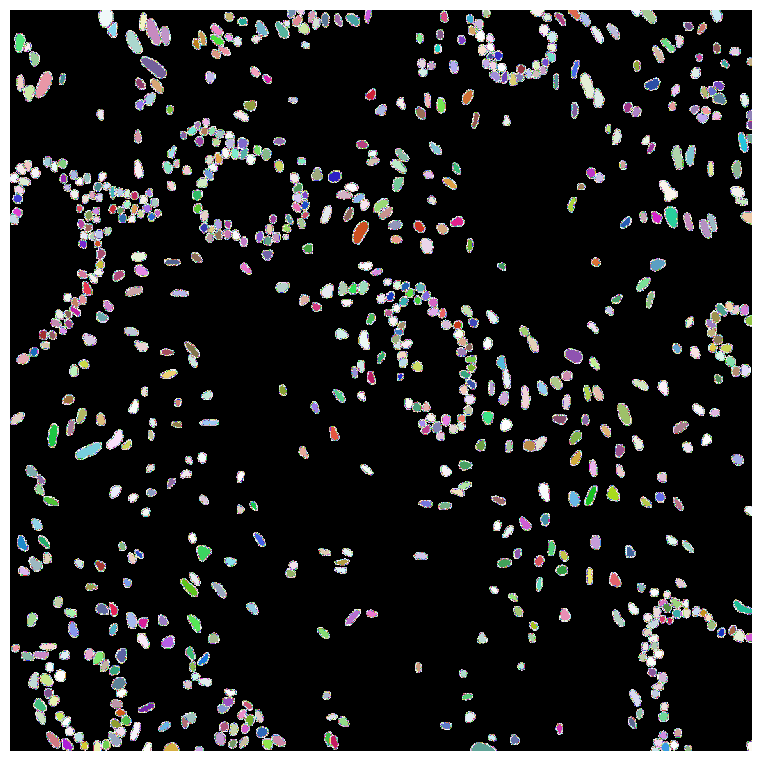

In [122]:
labels, polys = model.predict_instances(tile_im, normalizer=normalizer2)
show_tile(labels, cmap = cmap)

In [90]:
help(model.predict_instances)

Help on method _predict_instances_generator in module stardist.models.base:

_predict_instances_generator(img, axes=None, normalizer=None, sparse=True, prob_thresh=None, nms_thresh=None, scale=None, n_tiles=None, show_tile_progress=True, verbose=False, return_labels=True, predict_kwargs=None, nms_kwargs=None, overlap_label=None, return_predict=False) method of stardist.models.model2d.StarDist2D instance
    Predict instance segmentation from input image.
    
    Parameters
    ----------
    img : :class:`numpy.ndarray`
        Input image
    axes : str or None
        Axes of the input ``img``.
        ``None`` denotes that axes of img are the same as denoted in the config.
    normalizer : :class:`csbdeep.data.Normalizer` or None
        (Optional) normalization of input image before prediction.
        Note that the default (``None``) assumes ``img`` to be already normalized.
    sparse: bool
        If true, aggregate probabilities/distances sparsely during tiled
        predicti

In [93]:
result = model.predict_instances(tile_im, normalizer=normalizer2)

In [148]:
coords = result[1]['coord']
# print(len(coords[0][0]))
contours = []
for xy in coords:
    contour = []
    for i in range(len(xy[0])):
        p = [xy[0][i], xy[1][i]]  # [x, y]
        contour.append(p)
    contours.append(contour)

print(len(contours))

831


In [143]:
len(result[1]['points'])

831

In [160]:
# combine points and contours into 1 list

data_stardist = []
for i in range(len(result[1]['points'])):
    nucleus = result[1]['points'][i]
    contour = contours[i]
    both = [nucleus, contour]
    data_stardist.append(both)

In [161]:
for data in data_stardist:
    print(data)
    break

[array([226, 400], dtype=int64), [[226.0, 407.4812], [227.44438, 407.2614], [228.85686, 406.89706], [230.18465, 406.26276], [231.84033, 405.84033], [233.58957, 405.0712], [235.4985, 403.93442], [236.48676, 402.08594], [237.40767, 400.0], [236.57127, 397.89725], [235.74825, 395.96216], [233.96436, 394.67838], [232.37137, 393.62863], [230.64403, 393.04974], [229.14134, 392.41614], [227.47063, 392.6067], [226.0, 392.59235], [224.61879, 393.05618], [223.1758, 393.18176], [221.78276, 393.68845], [220.33739, 394.3374], [218.87462, 395.23898], [217.61633, 396.52737], [217.26678, 398.26285], [216.5651, 400.0], [217.05368, 401.77954], [217.63916, 403.46317], [218.81302, 404.8022], [220.089, 405.911], [221.3748, 406.9221], [222.86993, 407.55664], [224.47462, 407.66858]]]


Now, need to format the points / contours into json format so that it can be read into Qupath for annotations

In [135]:
import json
import geojson
from pathlib import Path

In [149]:
# correct format
type_info = Path(r"\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\qupath_json_format_file\monkey_fetus_40_0105_ecm.geojson")
info = json.load(open(type_info,'r'))#

In [150]:
info

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'id': '3f4b64b3-3379-4c41-b9c5-1de9c7f0ea83',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[163, 390],
      [163, 391],
      [162, 391],
      [162, 392],
      [161, 392],
      [161, 393],
      [160, 393],
      [160, 394],
      [159, 394],
      [159, 395],
      [159, 396],
      [159, 397],
      [159, 398],
      [160, 398],
      [160, 399],
      [161, 399],
      [161, 400],
      [162, 400],
      [162, 401],
      [163, 401],
      [163, 402],
      [164, 402],
      [164, 403],
      [166, 403],
      [166, 404],
      [166, 405],
      [166, 406],
      [166, 407],
      [166, 408],
      [166, 409],
      [166, 410],
      [166, 411],
      [167, 411],
      [167, 412],
      [168, 412],
      [168, 413],
      [173, 413],
      [173, 412],
      [177, 412],
      [177, 411],
      [178, 411],
      [178, 410],
      [179, 410],
      [179, 409],
      [179, 408],
      [179, 407],
      [17

In [214]:
GEOdata = []

points = []
count = 0

for centroid, contour in data_stardist:
    # xy coordinates are swapped, so I reverse them here with xy[::-1]
    contour = [[int(coord) for coord in xy[::-1]] for xy in contour]  # Convert coordinates to integers
    contour.append(contour[0]) # stardist doesn't close the circle, needed for qupath
    points.append(centroid)

    # Create a new dictionary for each contour
    dict_data = {
        "type": "Feature",
        "id": "PathCellObject",
        "geometry": {
            "type": "Polygon",
            "coordinates": [contour]
        },
        "properties": {
            'objectType': 'annotation',
            'classification': {'name': 'Nuclei', 'color': [97, 214, 59]}
        }
    }

    GEOdata.append(dict_data)
    count += 1

print(count)

831


In [215]:
for x in GEOdata:
    print(x)
    break

{'type': 'Feature', 'id': 'PathCellObject', 'geometry': {'type': 'Polygon', 'coordinates': [[[407, 226], [407, 227], [406, 228], [406, 230], [405, 231], [405, 233], [403, 235], [402, 236], [400, 237], [397, 236], [395, 235], [394, 233], [393, 232], [393, 230], [392, 229], [392, 227], [392, 226], [393, 224], [393, 223], [393, 221], [394, 220], [395, 218], [396, 217], [398, 217], [400, 216], [401, 217], [403, 217], [404, 218], [405, 220], [406, 221], [407, 222], [407, 224], [407, 226]]]}, 'properties': {'objectType': 'annotation', 'classification': {'name': 'Nuclei', 'color': [97, 214, 59]}}}


In [216]:
# type(GEOdata[0])
type(GEOdata[0]['geometry']['coordinates'][0][0][0])

int

In [217]:
print(GEOdata[:5])

[{'type': 'Feature', 'id': 'PathCellObject', 'geometry': {'type': 'Polygon', 'coordinates': [[[407, 226], [407, 227], [406, 228], [406, 230], [405, 231], [405, 233], [403, 235], [402, 236], [400, 237], [397, 236], [395, 235], [394, 233], [393, 232], [393, 230], [392, 229], [392, 227], [392, 226], [393, 224], [393, 223], [393, 221], [394, 220], [395, 218], [396, 217], [398, 217], [400, 216], [401, 217], [403, 217], [404, 218], [405, 220], [406, 221], [407, 222], [407, 224], [407, 226]]]}, 'properties': {'objectType': 'annotation', 'classification': {'name': 'Nuclei', 'color': [97, 214, 59]}}}, {'type': 'Feature', 'id': 'PathCellObject', 'geometry': {'type': 'Polygon', 'coordinates': [[[87, 1042], [86, 1043], [86, 1045], [85, 1046], [84, 1048], [83, 1049], [81, 1050], [79, 1050], [78, 1050], [76, 1050], [74, 1049], [73, 1048], [71, 1048], [70, 1046], [69, 1045], [69, 1043], [69, 1042], [69, 1040], [69, 1038], [70, 1036], [71, 1035], [72, 1033], [74, 1032], [76, 1032], [78, 1031], [79, 10

In [218]:
out_pth = Path(r'\\10.99.68.178\andreex\data\monkey fetus\gestational 40\1024tiles\stardist_segmented_jsons')
new_fn = WSIs[ind][:-5] + '.geojson'

print(new_fn)
with open(out_pth.joinpath(new_fn),'w') as outfile:
    geojson.dump(GEOdata,outfile)
print('Finished',new_fn)

monkey_fetus_40_0730_kidney.geojson
Finished monkey_fetus_40_0730_kidney.geojson
